In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch
from constants import regions

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

#Import sklearn modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


##### Create Features Dataframes

In [77]:
sys.argv[1] = 4
sys.argv[2] = 4

reduced_slide_list = [ (0.5, 0.5), (1, 0.5), (2, 0.5), (3, 0.5), (4, 0.5), (6, 0.5), (8, 0.5), (10, 1), (12, 1), (14, 1)]
super_reduced_slide_list = [ (0.5, 0.5), (1, 0.5), (2, 0.5), (4, 1), (6, 1), (8, 1), (10,1), (14, 1) ] 


# d_num = int( sys.argv[1] ), I never use this, originally I used this 
data_type = ['N2', 'N3','REM', 'Wake', 'N1'][4]


expt_num = 2

#2. Load the data based on data type ___________________________________________________________
df = pd.read_hdf(os.path.join(os.path.abspath('..'),'Multiple_PSDs_Per_Participant/' + data_type + 'processed_multiple_psds_per_person.h5') , key = 'df')

y = df['y'].copy()
groups = df['groups'].copy()

df = df.drop(columns = ['groups', 'y'])

regional_dfs = {}

for region in regions:
    
    single_region_df = df[[col for col in df.columns if col.endswith('_' + region)]]
    frequency_vals  = np.arange(0.5,40.125, 0.125)
    single_region_df.columns = frequency_vals
    
    folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
    # paths = joblib.load(folder + data_type + '_paths.pkl')
    
    # groups = pd.Series(paths['s_p_id'])
    # s_class_list = pd.Series(paths['s_class_list'])
    # y = s_class_list.map({'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3})
    
    #3 Generate the frequency band search space ____________________________________________________
    width_slide_list = [(0.5,0.5)] 
    for window_width in range(1, 15 ):
        width_slide_list.append((window_width, 0.5) )
    
    #4 Calculate all of the features ________________________________________________________________
    feature_dfs = []
    
    for window_width_hz, window_slide_hz in super_reduced_slide_list:
        description = 'window width : ' + str(window_width_hz) + ' .  window stride : ' + str(window_slide_hz)
        
        #1.Set Window width in Hz and Window Slide in Hz
        # window_width_hz = 3
        window_len = (window_width_hz/0.125)+1
        assert window_len%1 == 0
        window_len = int(window_len)
        
        # window_slide_hz = 0.5 
        window_slide_len = window_slide_hz/0.125 
        assert window_slide_len%1 == 0
        window_slide_len = int(window_slide_len)
        
        
        #2.Calculate band values and store in dataframe calculated_df
        
        # Start of the window is the middle_freq value minus window_width_hz/2 
        # End of the window is the middle freq value plus window_width_hz/2
        window_len
        
        middle_freq = []
        final_cols = []
        
        i = 0
        while i < len(frequency_vals) - window_len:
            middle_freq.append( frequency_vals[i:i+window_len].mean() )
            band_vals = single_region_df.iloc[:,i:i+window_len].mean(axis = 1) #For every row calculate the mean for the appropriate elements
            
            final_cols.append(band_vals)
            
            # scaled_psd.append( psd_values[i:i+factor].mean() )
            i+= window_slide_len
        
        calculated_df = pd.DataFrame(final_cols).T
        calculated_df.columns = middle_freq
        
        calculated_df.columns = [ str(col) + '_width_' + str(window_width_hz) for col in calculated_df.columns]
        
        
        #3.Calculate Information Gain Based on Features
        #Change to binary HC vs PD / PD+RBD ---> Generate expt specific X,y,groups 
        X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(calculated_df,y,groups,expt_num)
    
        feature_dfs.append(X_expt)
            
    #5 Concatenate all feature_dfs into a single dataframe_________________________________________________________________
    X_expt_concatenated = pd.concat(feature_dfs, axis=1)

    #6 Calculate Frequency Ratio Columns
    calculated_cols = []
    col_names = []
    
    X_expt_ratios = X_expt_concatenated.copy() 
    
    for col_1 in X_expt_concatenated.columns:
        for col_2 in X_expt_concatenated.columns:
            if col_1 == col_2:
                pass
            else:
                new_col = col_1 + '/' + col_2  
                col_names.append(new_col)
                calculated_cols.append( X_expt_concatenated[col_1]/X_expt_concatenated[col_2] )
    
    df_ratios = pd.concat(calculated_cols, axis = 1)
    df_ratios.columns = col_names
    df_ratios_and_freq = pd.concat([df_ratios, X_expt_concatenated], axis = 1)
    regional_dfs[region] = df_ratios_and_freq.copy()
    print(region + 'done!')

Prefrontaldone!


KeyboardInterrupt: 

### Model Functions (Fit, Predict, Accuracy Calculation)

In [42]:
def fit_model(X_train, y_train , thresh = 0.86): 
    ''' 
    To fit the model X_train and y_train is input. 
    Output:
    - DT1 , DT1 cols, DT2 , DT2 cols  
    '''
    def nonzero_indices(arr):
        return [index for index, value in enumerate(arr) if value != 0]

    #First fit DT1 
    DT = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes=3)
    DT.fit(X_train, y_train)
    cols_used_in_DT1 = [list(X_train.columns)[i] for i in nonzero_indices(DT.feature_importances_)]
    DT1 =  DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes=4)
    DT1.fit(X_train[cols_used_in_DT1] , y_train )

    #Use DT1 to make prob predictions and keep only data points below the specified confidence level
    max_preds_arr = DT1.predict_proba(X_train[cols_used_in_DT1]).max(axis = 1)
    max_preds_arr[ max_preds_arr < thresh]
    X_train_2 = X_train[max_preds_arr < thresh]
    y_train_2 = y_train[max_preds_arr < thresh]

    #Now fit DT2 using the tree fitting procedure 
    DT = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes=3)
    DT.fit(X_train_2, y_train_2)
    cols_used_in_DT2 = [list(X_train_2.columns)[i] for i in nonzero_indices(DT.feature_importances_)]

    DT2  =  DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes=4)
    DT2.fit(X_train_2[cols_used_in_DT2] , y_train_2 )

    return DT1, cols_used_in_DT1, DT2, cols_used_in_DT2    

In [12]:
def model_predict(DT1, cols_used_in_DT1, DT2,cols_used_in_DT2, X_test, thresh = 0.86): 
    ''' 
    Do the model predictions. 
    Input: 
    - thresh (Confidence level required to commit to prediction)
    
    Output:
    - Prediction array of length len(X_test)
  
    '''
    max_preds_arr = DT1.predict_proba(X_test[cols_used_in_DT1]).max(axis = 1)
    max_preds_arr[ max_preds_arr < thresh]
    
    # array of predictions
    preds_array = DT1.predict(X_test[cols_used_in_DT1])
    # Those predictions that are below the threshold are set to -1 (No prediction)
    preds_array[ max_preds_arr < thresh] = -1

    # Use second DT for predictions where the first DT did not suffice
    max_preds_arr_2 = DT2.predict_proba(X_test[cols_used_in_DT2]).max(axis = 1)
    preds_array_2 =  DT2.predict(X_test[cols_used_in_DT2])
    preds_array_2[max_preds_arr_2 < thresh] = -1

    #Combine prediction arrays from the two decision trees for the final predictions
    final_preds_array = preds_array.copy()
    
    for i in range(len(final_preds_array)):
        if final_preds_array[i] == -1 :
            final_preds_array[i] = preds_array_2[i]
        else:
            pass

    return final_preds_array

In [17]:
def model_acc(final_preds_array, y_test):
    '''
    - Output percentage of predictions made
    - Out of those predictions made, what percentage were correct?
    '''
    maybes = 0 
    for val in final_preds_array:
        if val == -1 : 
            maybes += 1
    percent_preds_made = 1 - ( maybes / len(final_preds_array) )

    total_preds = 0
    correct_preds = 0
    
    for i in range(len(final_preds_array)):
        if final_preds_array[i] == -1 : 
            pass
        else:
            total_preds += 1
            if final_preds_array[i] == y_test[i]:
                correct_preds +=1
            else: 
                pass
    correct_ratio = correct_preds / total_preds

    return correct_ratio , percent_preds_made

### Adhoc Code

In [4]:
from sklearn.tree import plot_tree
plot_tree(DT2)

In [31]:
from sklearn.model_selection import GroupKFold

### Fit, Predict and Evaluate

In [38]:
groups_expt

0      1101
1      1101
2      1101
3      1101
4      1101
       ... 
606    3306
607    3306
608    3306
609    3306
610    3306
Name: groups, Length: 399, dtype: object

In [37]:
y_expt

0      0
1      0
2      0
3      0
4      0
      ..
606    1
607    1
608    1
609    1
610    1
Name: y, Length: 399, dtype: int64

In [78]:
X_expt = regional_dfs['Prefrontal'].copy()
X_expt

0.75_width_0.5/1.25_width_0.5  0.75_width_0.5/1.75_width_0.5  \
0                          2.464548                       2.869931   
1                          1.579096                       2.569983   
2                          1.870470                       2.565580   
3                          2.695311                       4.511618   
4                          2.737497                       7.513375   
...                             ...                            ...   
3261                       0.560599                       0.843930   
3262                       1.235732                       3.084523   
3263                       1.867920                       3.246680   
3264                       1.109440                       2.380640   
3265                       0.697500                       0.700449   

      0.75_width_0.5/2.25_width_0.5  0.75_width_0.5/2.75_width_0.5  \
0                          7.490382                      10.842568   
1                          2.768382                       5.920487   
2                          5.975988                       6.125890   
3                          8.776850                      13.260215   
4                          9.154078                      14.955057   
...                             ...                            ...   
3261                       2.092486                       2.765220   
3262                       7.415533                      11.608993   
3263                       4.271823                       8.261420   
3264                       4.314992                       5.556374   
3265                       2.771909                       3.477381   

      0.75_width_0.5/3.25_width_0.5  0.75_width_0.5/3.75_width_0.5  \
0                         17.270330                      14.144145   
1                          7.136784                       8.419249   
2                          4.142193                       6.904813   
3                         15.075048                      10.487128   
4                          7.400668                      20.132290   
...                             ...                            ...   
3261                       4.110317                       4.476744   
3262                       9.684946                      14.730982   
3263                      12.139587                      15.741692   
3264                      10.063392                       6.196265   
3265                       4.233228                       5.535956   

      0.75_width_0.5/4.25_width_0.5  0.75_width_0.5/4.75_width_0.5  \
0                         11.809626                       7.680240   
1                          4.129877                       5.197716   
2                          3.182658                       4.375791   
3                         14.921609                      22.249805   
4                         17.058812                       6.502235   
...                             ...                            ...   
3261                       1.855117                       1.192717   
3262                      14.416018                      16.545219   
3263                      16.037865                       5.477012   
3264                       7.902006                      13.557129   
3265                      10.517972                       8.762637   

      0.75_width_0.5/5.25_width_0.5  0.75_width_0.5/5.75_width_0.5  ...  \
0                          7.053408                      13.652297  ...   
1                          2.952542                       3.348380  ...   
2                          5.207325                      14.208462  ...   
3                         22.016137                      19.801895  ...   
4                         11.647046                       9.509840  ...   
...                             ...                            ...  ...   
3261                       2.084656                       2.421119  ...   
3262                      24.866576       

In [90]:
y

0       0
1       0
2       0
3       0
4       0
       ..
3261    1
3262    1
3263    1
3264    1
3265    1
Name: y, Length: 2195, dtype: int64

In [43]:
for region in regions:
    X_expt = regional_dfs[region]

In [79]:
groups = groups_expt.copy()
X = X_expt.copy()
y = y_expt.copy()

In [81]:
num = 1
gkf = GroupKFold(n_splits = 5) 

pred_arrays = []

test_arrays = []

for train_index, test_index  in gkf.split(X, y, groups = groups.astype(int)*num):
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
                    #Fit model 
                    DT1, cols_used_in_DT1, DT2, cols_used_in_DT2 = fit_model(X_train, y_train , thresh = 0.9)
                    
                    #Make model predictions
                    final_preds_array = model_predict(DT1, cols_used_in_DT1, DT2,cols_used_in_DT2, X_test, thresh = 0.9)

                    #Append pred arrays and test arrays to list 
                    pred_arrays.append(final_preds_array)
                    test_arrays.append(y_test)
                    print('done another juan ...!')

done another juan ...!
done another juan ...!


KeyboardInterrupt: 

[Text(0.3333333333333333, 0.875, 'x[0] <= 2.244\nentropy = 0.91\nsamples = 1586\nvalue = [516, 1070]'),
 Text(0.16666666666666666, 0.625, 'entropy = 0.427\nsamples = 402\nvalue = [35, 367]'),
 Text(0.5, 0.625, 'x[1] <= 1.85\nentropy = 0.974\nsamples = 1184\nvalue = [481, 703]'),
 Text(0.3333333333333333, 0.375, 'entropy = 0.997\nsamples = 681\nvalue = [361, 320]'),
 Text(0.6666666666666666, 0.375, 'x[0] <= 14.379\nentropy = 0.793\nsamples = 503\nvalue = [120, 383]'),
 Text(0.5, 0.125, 'entropy = 0.867\nsamples = 326\nvalue = [94, 232]'),
 Text(0.8333333333333334, 0.125, 'entropy = 0.602\nsamples = 177\nvalue = [26, 151]')]

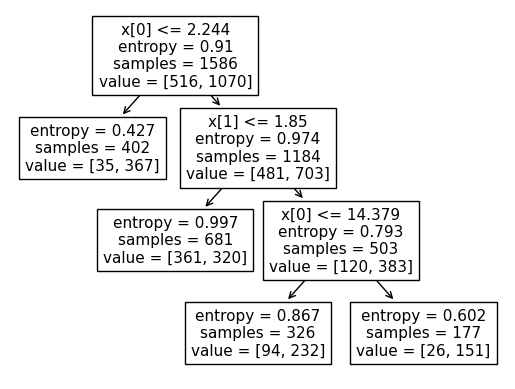

In [91]:
plot_tree(DT2)

In [82]:
final_preds = np.concatenate(pred_arrays)
final_test = np.concatenate(test_arrays)

correct_ratio , percent_preds_made = model_acc(final_preds, final_test)

In [87]:
correct_ratio

0.36

In [83]:
percent_preds_made

0.11376564277588164

In [21]:
X_expt = regional_dfs['Prefrontal']
X_train = regional_dfs['Prefrontal'].copy()
y_train = y_expt.copy()
X_test = X_train.copy()

In [11]:
t1 = time.time()
DT1, cols_used_in_DT1, DT2, cols_used_in_DT2 = fit_model(X_train, y_train , thresh = 0.86)
t2 = time.time()
t2-t1

56.54256319999695

In [18]:
final_preds_array = model_predict(DT1, cols_used_in_DT1, DT2,cols_used_in_DT2, X_test, thresh = 0.86)
correct_ratio , percent_preds_made = model_acc(final_preds_array, y_train.values)